In [1]:
import numpy as np
import matplotlib.pyplot as plt
from TWA_Design_Tools import TWA_Design_Toolkit

In [2]:
# Enter the physical parameters of the antenna 
num_straps = 11
f0 = 96e6
w0 = 2*np.pi*f0
clight = 3e8
Rant = 1.12 # m, hfs of d3d

# See code logbook "my antenna" section. This is for shot 147634. 
n_par = -5 
k_par = w0*n_par/clight
print(f'k_par : {k_par} 1/m')
n_phi = Rant*k_par
print(f'n_phi: {n_phi}')

myTWA = TWA_Design_Toolkit(num_straps=num_straps, f0=f0, k_par_max=k_par)
myTWA.print_key_params()
myTWA.set_center_fed(True)
# set my antenna width to 50% of the distance between straps 
# myTWA.set_strap_width(w=10e-2) TODO: this has been updated 
myTWA.set_strap_width(w=8e-2)
print(f'Strap width: {myTWA.wstr*100} cm')

k_par : -10.053096491487338 1/m
n_phi: -11.25946807046582
You are at resonance, so delta_phi = pi/2. Solving for d given k_par:


----------------Parameter--Box-------------------
Distance between strap centers d = 0.15625 m
The first null will be at 3.655671451449941 m^-1
delta_phi = -0.5 pi
Strap length should be less than lambda/4 = 0.7807095260416667 m
--------------END--Parameter--Box----------------


The antenna length is 1.6425 m long
Strap width: 8.0 cm


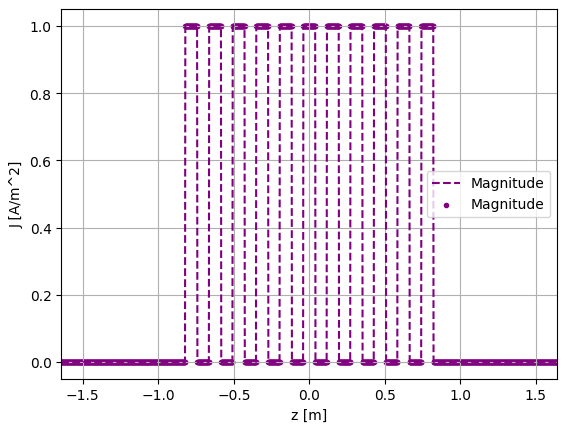

In [3]:
zrange = 100
num_points = int(1e5) # number of grid points for the z grid
zlim = 2*(num_straps*myTWA.wstr + (num_straps-1)*(myTWA.d - myTWA.wstr))/2
plt.xlim(-zlim, zlim)
myTWA.plot_J_of_z(J0=1, zmin=-zrange, zmax=zrange, num_points=num_points)

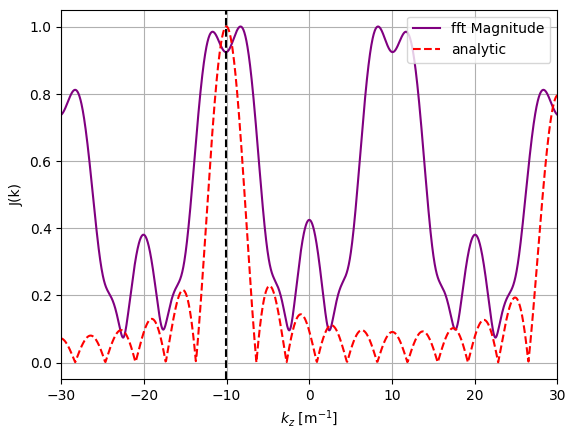

In [4]:
myTWA.plot_J_k_versus_k(zmin=-zrange, zmax=zrange, kplotmin=-30, kplotmax=30, num_pointsz=num_points, num_pointsk=1000, J0=1)

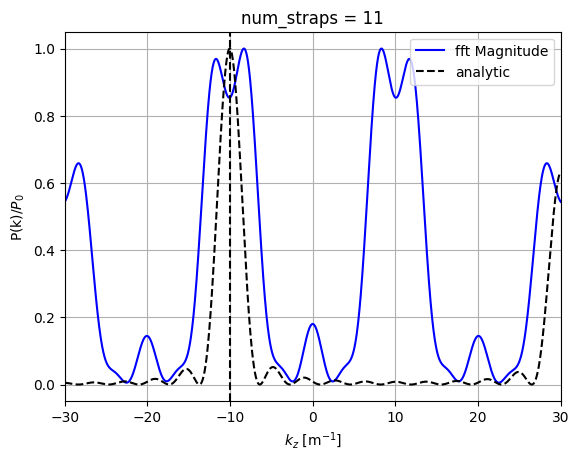

In [5]:
plt.title(f'num_straps = {num_straps}')
myTWA.plot_normalized_power_versus_k(zmin=-zrange, zmax=zrange, kplotmin=-30, kplotmax=30, num_pointsz=num_points, num_pointsk=1000, J0=1)


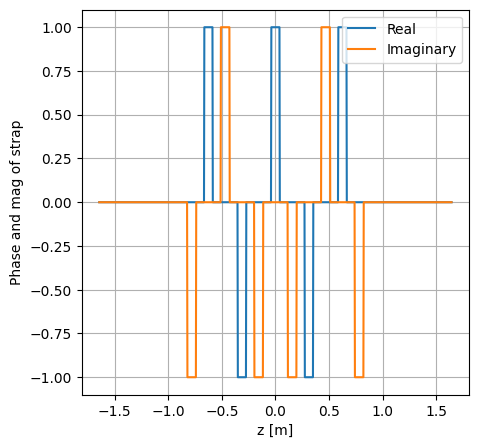

In [6]:
zarray = np.linspace(-zlim, zlim, 1000)
Jarray = np.zeros_like(zarray, dtype='complex')

for i in range(zarray.shape[0]):
    Jarray[i] = myTWA.get_J_z_centerfed(1, zarray[i])

fig, ax = plt.subplots(1,1, figsize=(5,5))

ax.plot(zarray, np.real(Jarray), label='Real')
ax.plot(zarray, np.imag(Jarray), label='Imaginary')
ax.grid()
ax.set_xlabel('z [m]')
ax.set_ylabel('Phase and mag of strap')
ax.legend()

The port characteristic impedence is Z0 = 83.12100040448948
C0 =  28.517403458184557  pF
w: 0.08
h: 0.01
h2: 0.0025
A: 0.008052124310533251 m^2
l: 0.10065155388166563
d: 0.15625
C0check 28.517403458184557  pF
Cno_cap:  0.70832 pF
Ch2:  2.83328 pF
Cadd_check:  28.51740345818456 pF


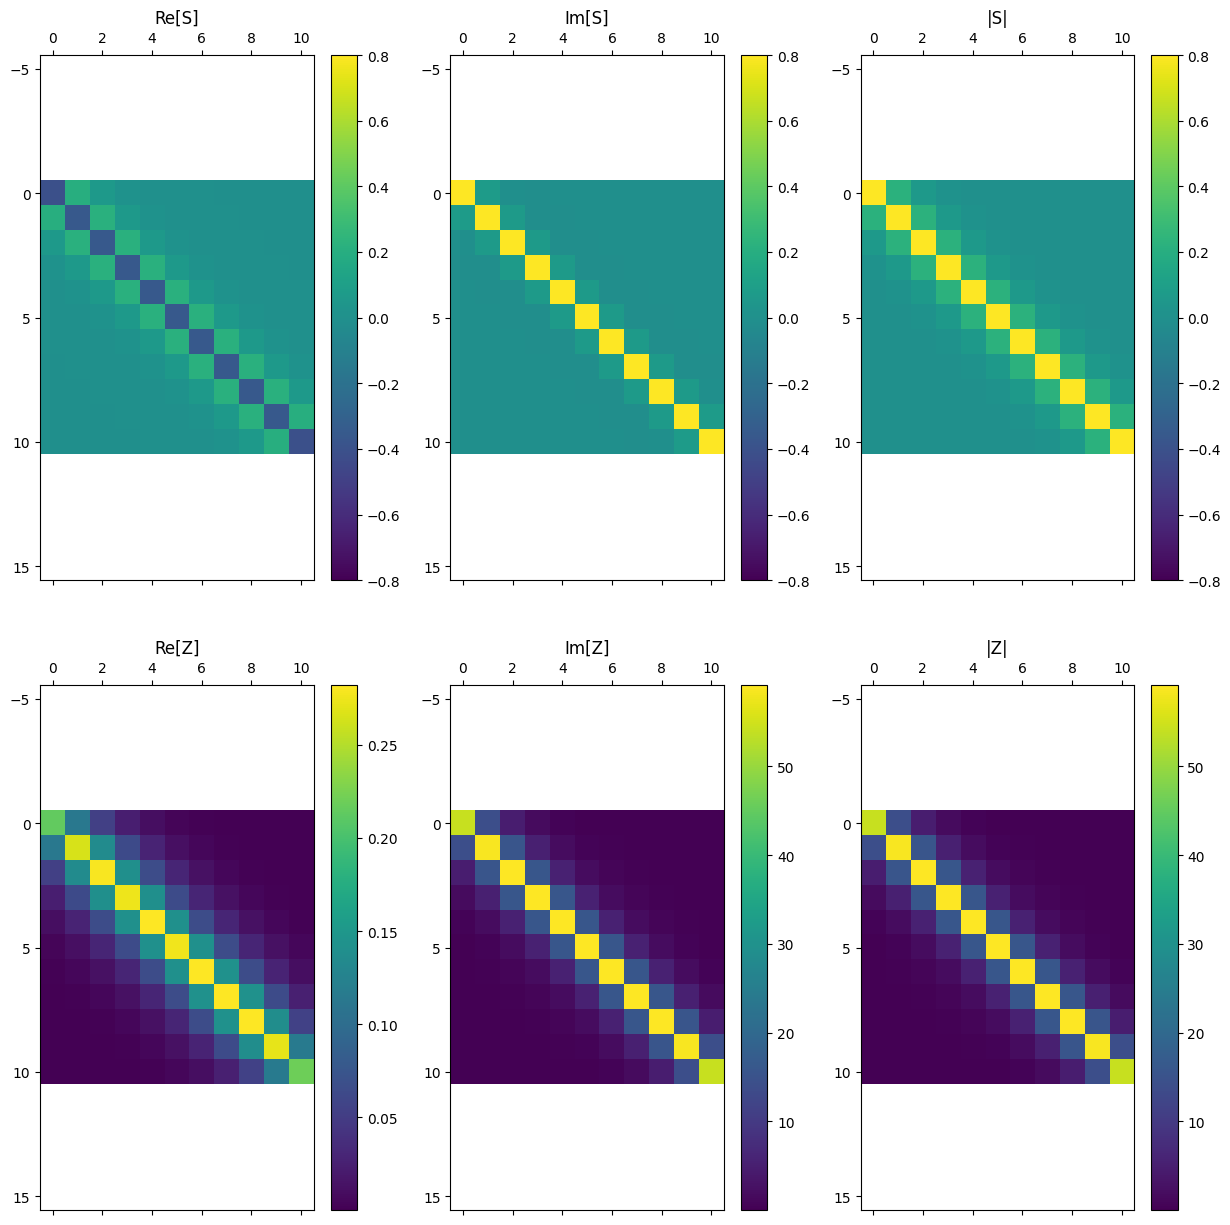

In [7]:
## S and Z matrix Section 
Smatrix_file_name = 'Smat_comsol_passive_dg_centerfed.csv'#'Smat_comsol_centerfed.csv'#
Smat = myTWA.read_Smat_from_comsol_portscan_Stable(filename=Smatrix_file_name, return_flag=True)
#print(Smat[1,:])
# Z0 = myTWA.get_coax_Z0(d_outer=0.016, d_inner=0.004)
Z0 = myTWA.get_coax_Z0(d_outer=0.008, d_inner=0.002)
myTWA.get_Z_matrix(Z0_port=Z0)
print(f'The port characteristic impedence is Z0 = {Z0}')
print('C0 = ', myTWA.calculate_C0()/1e-12, ' pF')


ts = 1e-2 #2e-2 # m TODO: updated this 
h = .01
h2 = h/4
w = myTWA.wstr
print(f'w: {w}')
print(f'h: {h}')
print(f'h2: {h2}')
A = myTWA.cap_area_given_gap(h2)
l = A/w
print(f'A: {A} m^2')
print(f'l: {l}')
print(f'd: {myTWA.d}')

Zav = np.trace(np.imag(myTWA.Zmatrix))/num_straps
C0check = 1/(Zav*w0)
print('C0check', C0check*1e12, ' pF')
Cno_cap = myTWA.epsi0*myTWA.wstr*ts/h
print('Cno_cap: ', Cno_cap/1e-12, 'pF')
Ch2 = myTWA.epsi0*myTWA.wstr*ts/h2
print('Ch2: ', Ch2/1e-12, 'pF')
Cadd_check  = myTWA.epsi0*myTWA.wstr*l/h2
print('Cadd_check: ', Cadd_check/1e-12, 'pF')
myTWA.plot_Smat_and_Zmat()

In [8]:
# load up the frequecy scan 
import csv
filename = 'fscan_centerfed_passive_dg_65_to_136.csv'#'fscan_centerfed_70to122.csv'
def get_fscan_data_centerfed(filename):
    data = []
    with open(filename, 'r') as file:
        reader = csv.reader(file)
        for row in reader:
            data.append(row)
    data = data[5:]
    fmat_string  = []
    for row in data:
        fmat_string.append(row)
    fmat = np.array([[complex(num.replace('i', 'j')) for num in row] for row in fmat_string], dtype=complex)
    fs = np.real(fmat[:,0])
    S12_abs = np.abs(fmat[:,1])
    S22_abs = np.abs(fmat[:,2])
    S32_abs = np.abs(fmat[:,3])
    S12_plus_32_abs = np.sqrt(S12_abs**2 + S32_abs**2)
    S12_db = 20*np.log10(S12_abs)
    S32_db = 20*np.log10(S32_abs)
    S22_db = 20*np.log10(S22_abs) # TODO: change this back
    S12_plus_32_db = 20*np.log10(S12_plus_32_abs)
    return fs, S12_abs, S12_db, S22_abs, S22_db, S32_abs, S32_db, S12_plus_32_abs, S12_plus_32_db

def get_hf_scan_data_centerfed(filename):
    data = []
    with open(filename, 'r') as file:
        reader = csv.reader(file)
        for row in reader:
            data.append(row)
    data = data[5:]
    fmat_string  = []
    for row in data:
        fmat_string.append(row)
    fmat = np.array([[complex(num.replace('i', 'j')) for num in row] for row in fmat_string], dtype=complex)
    hs = np.real(fmat[:,0])
    fs = np.real(fmat[:,1])
    S12 = np.abs(fmat[:,2])
    S22 = np.abs(fmat[:,3])
    S32 = np.abs(fmat[:,4])
    S12_plus_32 = np.sqrt(S12**2 + S32**2)
    S12_db = 20*np.log10(S12)
    S32_db = 20*np.log10(S32)
    S22_db = 20*np.log10(S22) # TODO: change this back
    S12_plus_32_db = 20*np.log10(S12_plus_32)
    return hs, fs, S12, S12_db, S22, S22_db, S32, S32_db, S12_plus_32, S12_plus_32_db

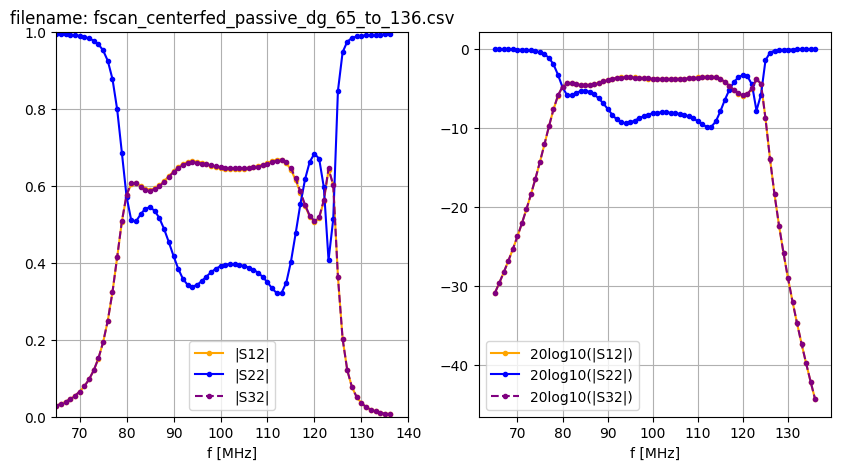

In [9]:
filename = 'fscan_centerfed_passive_dg_65_to_136.csv'#'fscan_centerfed_65to136.csv'fscan_capfed_centerfed_62to138
fs, S12_abs, S12_db, S22_abs, S22_db, S32_abs, S32_db, S12_plus_32_abs, S12_plus_32_db = get_fscan_data_centerfed(filename)

fig, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].plot(fs, S12_abs, label='|S12|', color='orange', marker='.')
ax[0].plot(fs, S22_abs, label='|S22|', color='blue', marker='.')
ax[0].plot(fs, S32_abs, label='|S32|', color='purple', marker='.', linestyle='--')
ax[0].legend()
ax[0].set_xlabel('f [MHz]')
ax[0].grid()
ax[0].set_title(f'filename: {filename}')
ax[0].set_xlim(65, 140)
ax[0].set_ylim(0, 1)

ax[1].plot(fs, S12_db, label='20log10(|S12|)', color='orange', marker='.')
ax[1].plot(fs, S22_db, label='20log10(|S22|)', color='blue', marker='.')
ax[1].plot(fs, S32_db, label='20log10(|S32|)', color='purple', marker='.', linestyle='--')
ax[1].legend()
ax[1].set_xlabel('f [MHz]')
ax[1].grid()
# ax[1].set_xlim(65, 140)
# ax[1].set_ylim(0, 1)


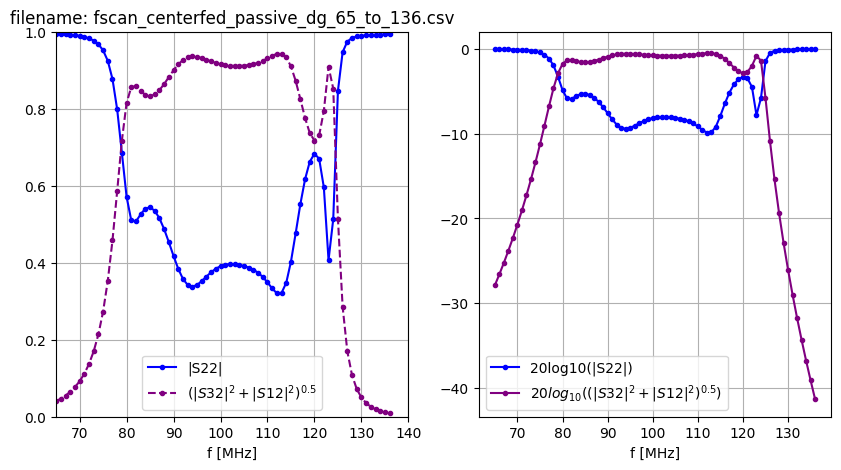

In [10]:
fig, ax = plt.subplots(1,2, figsize=(10,5))

ax[0].plot(fs, S22_abs, label='|S22|', color='blue', marker='.')
ax[0].plot(fs, S12_plus_32_abs, label=r'$(|S32|^2 + |S12|^2)^{0.5}$', color='purple', marker='.', linestyle='--')
ax[0].legend()
ax[0].set_xlabel('f [MHz]')
ax[0].grid()
ax[0].set_title(f'filename: {filename}')
ax[0].set_xlim(65, 140)
ax[0].set_ylim(0, 1)

ax[1].plot(fs, S22_db, label='20log10(|S22|)', color='blue', marker='.')
ax[1].plot(fs, S12_plus_32_db, label=r'$20log_{10}((|S32|^2 + |S12|^2)^{0.5})$', color='purple', marker='.')
ax[1].legend()
ax[1].set_xlabel('f [MHz]')
ax[1].grid()

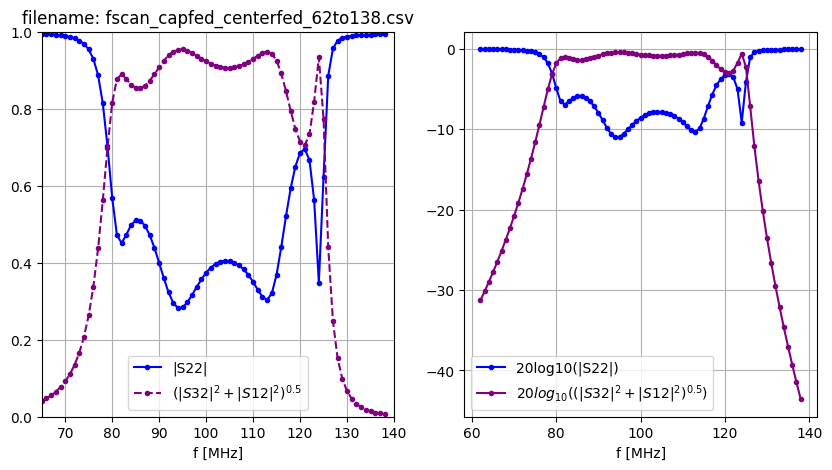

In [11]:
filename= 'fscan_capfed_centerfed_62to138.csv'

fs, S12_abs, S12_db, S22_abs, S22_db, S32_abs, S32_db, S12_plus_32_abs, S12_plus_32_db = get_fscan_data_centerfed(filename)

fig, ax = plt.subplots(1,2, figsize=(10,5))

ax[0].plot(fs, S22_abs, label='|S22|', color='blue', marker='.')
ax[0].plot(fs, S12_plus_32_abs, label=r'$(|S32|^2 + |S12|^2)^{0.5}$', color='purple', marker='.', linestyle='--')
ax[0].legend()
ax[0].set_xlabel('f [MHz]')
ax[0].grid()
ax[0].set_title(f'filename: {filename}')
ax[0].set_xlim(65, 140)
ax[0].set_ylim(0, 1)

ax[1].plot(fs, S22_db, label='20log10(|S22|)', color='blue', marker='.')
ax[1].plot(fs, S12_plus_32_db, label=r'$20log_{10}((|S32|^2 + |S12|^2)^{0.5})$', color='purple', marker='.')
ax[1].legend()
ax[1].set_xlabel('f [MHz]')
ax[1].grid()

Text(0.5, 0, 'h_feed [cm]')

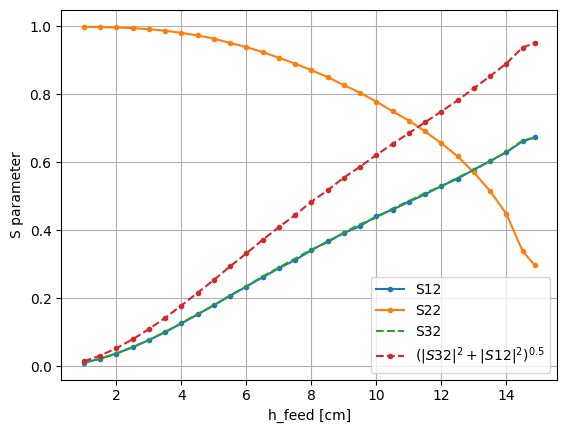

In [12]:
# this is for feed position scan plots 
filename = 'hf_scan_centerfed_flat_96_MHz.csv'
hs, fs, S12, S12_db, S22, S22_db, S32, S32_db, S12_plus_32, S12_plus_32_db = get_hf_scan_data_centerfed(filename)

plt.plot(hs, S12, label='S12', marker='.')
plt.plot(hs, S22, label='S22',marker='.')
plt.plot(hs, S32, label='S32', linestyle='--')
plt.plot(hs, S12_plus_32, label=r'$(|S32|^2 + |S12|^2)^{0.5}$', linestyle='--', marker='.')
plt.grid()
plt.legend()
plt.ylabel('S parameter')
plt.xlabel('h_feed [cm]')

The port characteristic impedence is Z0 = 83.12100040448948
C0 =  36.561203876802324  pF
C1 =  73.12240775360465  pF
w: 0.08
h: 0.01
h2: 0.001
A: 0.008258686215677057 m^2
l: 0.10323357769596321
d: 0.15625
C0check 36.561203876802324  pF
Cno_cap:  0.70832 pF
Ch2:  7.0832 pF
Cadd_check:  73.12240775360465 pF


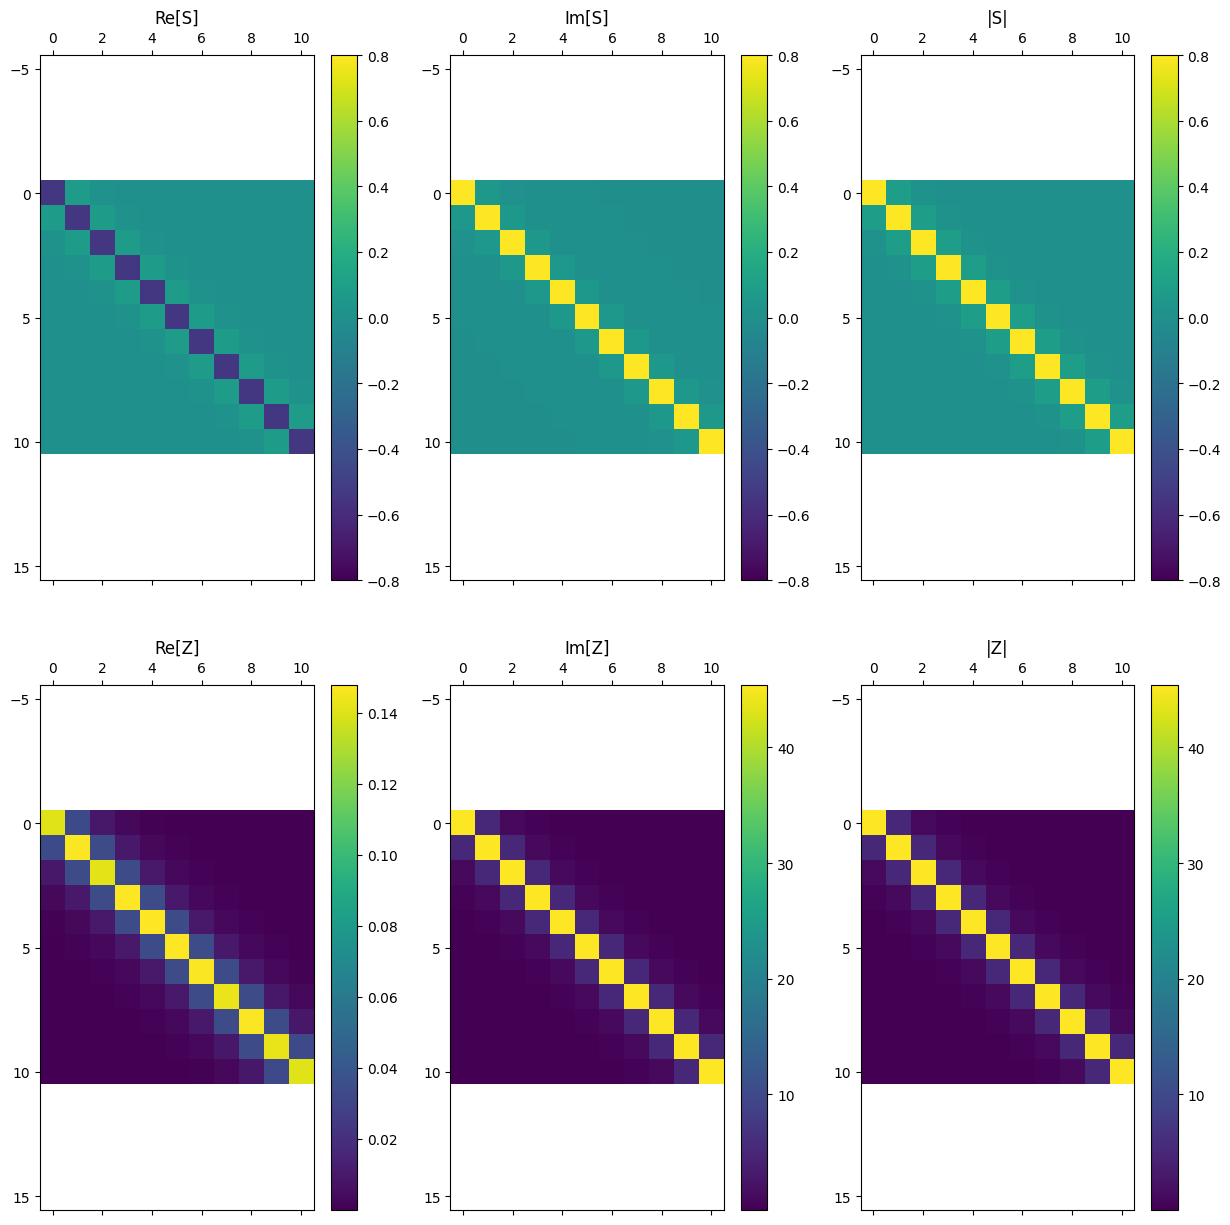

In [16]:
# T type 
## S and Z matrix Section 
Smatrix_file_name = 'Smat_T_flat_11_strap.csv'#'Smat_comsol_centerfed.csv'#
Smat = myTWA.read_Smat_from_comsol_portscan_Stable(filename=Smatrix_file_name, return_flag=True)
#print(Smat[1,:])
# Z0 = myTWA.get_coax_Z0(d_outer=0.016, d_inner=0.004)
Z0 = myTWA.get_coax_Z0(d_outer=0.008, d_inner=0.002)
myTWA.get_Z_matrix(Z0_port=Z0)
print(f'The port characteristic impedence is Z0 = {Z0}')
print('C0 = ', myTWA.calculate_C0()/1e-12, ' pF')
print('C1 = ', myTWA.calculate_C1()/1e-12, ' pF')

ts = 1e-2 #2e-2 # m TODO: updated this 
h = .01
h2 = h/10
w = myTWA.wstr
print(f'w: {w}')
print(f'h: {h}')
print(f'h2: {h2}')
A = myTWA.cap_area_given_gap_and_C(h2, myTWA.calculate_C1())
l = A/w
print(f'A: {A} m^2')
print(f'l: {l}')
print(f'd: {myTWA.d}')

Zav = np.trace(np.imag(myTWA.Zmatrix))/num_straps
C0check = 1/(Zav*w0)
print('C0check', C0check*1e12, ' pF')
Cno_cap = myTWA.epsi0*myTWA.wstr*ts/h
print('Cno_cap: ', Cno_cap/1e-12, 'pF')
Ch2 = myTWA.epsi0*myTWA.wstr*ts/h2
print('Ch2: ', Ch2/1e-12, 'pF')
Cadd_check  = myTWA.epsi0*myTWA.wstr*l/h2
print('Cadd_check: ', Cadd_check/1e-12, 'pF')
myTWA.plot_Smat_and_Zmat()

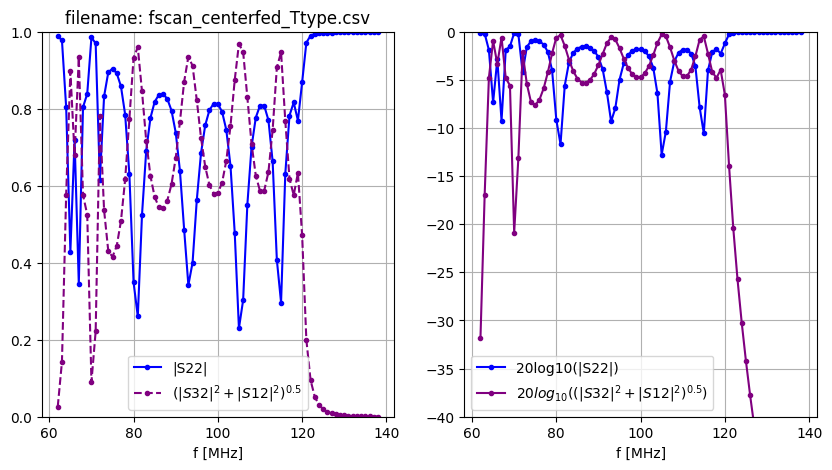

In [21]:
filename = 'fscan_centerfed_Ttype.csv'#'fscan_centerfed_65to136.csv'fscan_capfed_centerfed_62to138
fs, S12_abs, S12_db, S22_abs, S22_db, S32_abs, S32_db, S12_plus_32_abs, S12_plus_32_db = get_fscan_data_centerfed(filename)

fig, ax = plt.subplots(1,2, figsize=(10,5))

ax[0].plot(fs, S22_abs, label='|S22|', color='blue', marker='.')
ax[0].plot(fs, S12_plus_32_abs, label=r'$(|S32|^2 + |S12|^2)^{0.5}$', color='purple', marker='.', linestyle='--')
ax[0].legend()
ax[0].set_xlabel('f [MHz]')
ax[0].grid()
ax[0].set_title(f'filename: {filename}')
#ax[0].set_xlim(62, 140)
ax[0].set_ylim(0, 1)

ax[1].plot(fs, S22_db, label='20log10(|S22|)', color='blue', marker='.')
ax[1].plot(fs, S12_plus_32_db, label=r'$20log_{10}((|S32|^2 + |S12|^2)^{0.5})$', color='purple', marker='.')
ax[1].legend()
ax[1].set_xlabel('f [MHz]')
ax[1].set_ylim(-40, 0)
ax[1].grid()
